# Import Library and Data

In [ ]:
# Standard library
import pandas as pd
import geopandas as gpd
import numpy as np
import joblib
import time
import re

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Library
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.cluster import KMeans
import pickle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/merged_data_energy_pluto.csv', index_col=0) # change data path
data

,property_id,nyc_borough_block_and_lot_bbl,city,postal_code,national_median_reference_property_type,largest_property_use_type,largest_property_use_type__gross_floor_area_ft²,year_built,construction_status,number_of_buildings,occupancy,metered_areas_energy,energy_star_score,national_median_energy_star_score,energy_star_certification__eligibility,site_eui_kbtuft²,weather_normalized_site_energy_use_kbtu,weather_normalized_site_electricity_intensity_kwhft²,source_eui_kbtuft²,weather_normalized_source_eui_kbtuft²,national_median_source_eui_kbtuft²,source_energy_use_kbtu,weather_normalized_source_energy_use_kbtu,electricity_use__grid_purchase_kbtu,electricity_use__grid_purchase_kwh,weather_normalized_site_electricity_kwh,percent_of_electricity_that_is_green_power,number_of_active_energy_meters__total,site_energy_use_kbtu,multifamily_housing__government_subsidized_housing,multifamily_housing__gross_floor_area_ft²,multifamily_housing__number_of_bedrooms,multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft,multifamily_housing__number_of_laundry_hookups_in_all_units,multifamily_housing__number_of_laundry_hookups_in_common_areas,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories,multifamily_housing__total_number_of_residential_living_units,multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft,multifamily_housing__percent_that_can_be_cooled,multifamily_housing__percent_that_can_be_heated,borough,block,lot,bct2020,bctcb2020,healthcenterdistrict,zonedist1,bldgclass,landuse,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,numbldgs,numfloors,unitsres,unitstotal,ext,proxcode,lottype,assessland,assesstot,builtfar,bbl,latitude,longitude,_merge
0,21205224.0,4006520042,Long Island City,11103.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,25000.0,2010.0,Existing,1.0,100.0,Whole Property,71.0,50.0,False,66.7,1758894.6,7.0,112.3,115.4,128.1,2806470.4,2885158.1,603862.9,176982.1,173893.6,0.0,8.0,1666390.8,False,25000.0,30.00,1.20000,0.0,6.0,0.0,25.0,1.00000,0.00000,25.0,1.00000,0.0,100.0,QN,652.0,42.0,4006502.0,4.006502e+10,41.0,R6B,D7,4.0,6690.0,34146.0,4000.0,30146.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,25.0,26.0,N,0.0,5.0,170550.0,1727100.0,5.10,4006520042,40.769008,-73.913395,both
1,2665352.0,1012060001,New York,10025.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,260780.0,1970.0,Existing,1.0,100.0,Whole Property,100.0,50.0,False,19.2,5022480.9,4.7,48.2,48.2,114.3,12615136.7,12615136.7,4195161.0,1229531.2,1229531.2,0.0,6.0,5022480.9,False,260780.0,317.00,1.21558,0.0,1.0,208.0,208.0,0.79761,0.79761,0.0,0.00000,0.0,100.0,MN,1206.0,1.0,1017700.0,1.017701e+10,16.0,C1-9,D7,4.0,25177.0,244841.0,33619.0,211222.0,2102.0,0.0,31517.0,0.0,0.0,1.0,30.0,203.0,205.0,N,1.0,3.0,1125000.0,8226000.0,9.72,1012060001,40.790459,-73.968816,both
2,2665400.0,1018320043,New York,10025.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,324378.0,1943.0,Existing,1.0,100.0,Whole Property,84.0,50.0,False,66.9,23986513.6,3.9,93.3,98.6,121.4,31096872.8,32851011.0,4380098.1,1283733.2,1283733.2,0.0,3.0,22315905.8,False,324378.0,427.00,1.31636,0.0,1.0,258.0,258.0,0.79537,0.79537,0.0,0.00000,0.0,100.0,MN,1832.0,43.0,1018100.0,1.018101e+10,16.0,R9,D3,3.0,42538.0,349740.0,27200.0,322540.0,20000.0,0.0,7200.0,0.0,0.0,1.0,14.0,247.0,258.0,N,1.0,5.0,900000.0,9938250.0,8.22,1018320043,40.792808,-73.965908,both
3,2665405.0,1001420025,New York,10013.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,1039841.0,1975.0,Existing,3.0,100.0,Whole Property,3.0,50.0,False,113.8,134732083.7,6.7,161.3,167.3,100.0,1795

# Data Inspection & Cleaning

TARGET = 'site_energy_use_kbtu'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9101 entries, 0 to 9257
Data columns (total 75 columns):
 #   Column                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                        --------------  -----  
 0   property_id                                                                                                   9101 non-null   float64
 1   nyc_borough_block_and_lot_bbl                                                                                 9101 non-null   int64  
 2   city                                                                                                          9101 non-null   object 
 3   postal_code                                                                                                   9101 non-null   float64
 4   national_median_reference_property_type                    

In [ ]:
# Describe numerical features
data.describe()

,property_id,nyc_borough_block_and_lot_bbl,postal_code,largest_property_use_type__gross_floor_area_ft²,year_built,number_of_buildings,occupancy,energy_star_score,national_median_energy_star_score,site_eui_kbtuft²,weather_normalized_site_energy_use_kbtu,weather_normalized_site_electricity_intensity_kwhft²,source_eui_kbtuft²,weather_normalized_source_eui_kbtuft²,national_median_source_eui_kbtuft²,source_energy_use_kbtu,weather_normalized_source_energy_use_kbtu,electricity_use__grid_purchase_kbtu,electricity_use__grid_purchase_kwh,weather_normalized_site_electricity_kwh,percent_of_electricity_that_is_green_power,number_of_active_energy_meters__total,site_energy_use_kbtu,multifamily_housing__gross_floor_area_ft²,multifamily_housing__number_of_bedrooms,multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft,multifamily_housing__number_of_laundry_hookups_in_all_units,multifamily_housing__number_of_laundry_hookups_in_common_areas,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories,multifamily_housing__total_number_of_residential_living_units,multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft,multifamily_housing__percent_that_can_be_cooled,multifamily_housing__percent_that_can_be_heated,block,lot,bct2020,bctcb2020,healthcenterdistrict,landuse,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,numbldgs,numfloors,unitsres,unitstotal,proxcode,lottype,assessland,assesstot,builtfar,bbl,latitude,longitude
count,9.101000e+03,9.101000e+03,9101.000000,9.101000e+03,9101.000000,9101.000000,9101.000000,9101.000000,9101.0,9101.000000,9.101000e+03,9101.000000,9101.000000,9101.000000,9101.000000,9.101000e+03,9.101000e+03,9.100000e+03,9.100000e+03,9.101000e+03,9098.000000,9101.000000,9.101000e+03,9.101000e+03,9101.00000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9.101000e+03,9.101000e+03,9101.000000,9101.000000,9.101000e+03,9.101000e+03,9101.000000,9.101000e+03,9101.000000,9101.000000,9101.00000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9101.000000,9.101000e+03,9.101000e+03,9101.000000,9.101000e+03,9100.000000,9100.000000
mean,6.509342e+06,2.254035e+09,10633.597187,1.036399e+05,1949.442699,1.190858,98.878145,58.707834,50.0,79.947643,8.536678e+06,5.216295,115.632370,119.517646,122.374201,1.216281e+07,1.252916e+07,2.057047e+06,6.028860e+05,5.909605e+05,0.022909,7.894957,8.118840e+06,1.036399e+05,144.30801,1.496033,16.668509,5.074892,42.969124,94.082933,0.983923,0.203749,41.439045,0.597871,73.531905,96.868858,2977.230964,1239.172399,2.254963e+06,2.254963e+10,26.235798,3.169432,2.734500e+04,1.059752e+05,7042.333809,9.765605e+04,1066.435557,2379.156027,2375.16240,124.347654,8.155368,1.768487,8.921877,99.435007,102.433579,0.927371,3.742116,1.188682e+06,7.789091e+06,5.410193,2.254035e+09,40.755911,-73.933132
std,4.415036e+06,1.130877e+09,552.906992,1.840457e+05,33.029446,2.322453,5.999962,28.761880,0.0,37.444663,1.382594e+07,2.986320,46.145997,48.168623,16.484347,1.988855e+07,2.058817e+07,3.655267e+06,1.071297e+06,1.076647e+06,0.523468,9.148804,1.308912e+07,1.840457e+05,265.19233,0.549041,67.258211,10.975838,174.752361,172.131410,0.320580,0.398373,55.435191,0.525363,37.594061,10.343608,2427.106493,2728.994841,1.133566e+06,1.133566e+10,11.034840,0.792044,8.495660e+04,2.129213e+05,23724.787201,1.990481e+05,9376.342201,8187.386397,12766.95771,1611.164184,350.834763,6.756204,7.366467,223.013601,224.583190,1.140512,1.500027,3.295312e+06,1.795699e+07,3.773763,1.130877e+09,0.08

In [ ]:
# Describe categorical features
data.describe(include='object').T

,count,unique,top,freq
city,9101,92,New York,2878
national_median_reference_property_type,9101,2,Fannie Mae Industry Survey - Multifamily,9100
largest_property_use_type,9101,1,Multifamily Housing,9101
construction_status,9101,1,Existing,9101
metered_areas_energy,9101,1,Whole Property,9101
borough,9101,5,MN,3306
zonedist1,9100,139,R6,1238
bldgclass,9101,54,D1,2170
ext,9101,5,N,6966
_merge,9101,1,both,9101


In [ ]:
# Check data shape
data.shape

(9101, 75)

In [ ]:
# Exclude 0 values in target variables
data = data[data['site_energy_use_kbtu'] != 0]
data.shape

(9099, 75)

In [ ]:
# Remove duplicate
data = data.drop_duplicates(keep='first')
data.shape

(9076, 75)

In [ ]:
# # Exclude data that has year_built before 1850
# data = data[data['year_built'] >= 1850]
# data.shape

In [ ]:
# Change data types (since we still have some categorical data in numerical form)
for feature in ['proxcode', 'lottype', 'landuse']:
  data[feature] = data[feature].astype(str)

In [ ]:
# # Change values for land use and ext (to make them more intuitive)
# mapping = {'2.0': 'Multi-Family Walk-Up Buildings',
#            '3.0': 'Multi-Family Elevator Buildings',
#            '4.0': 'Mixed Residential & Commercial Buildings',
#            '5.0': 'Commercial & Office Buildings',
#            '6.0': 'Industrial & Manufacturing',
#            '8.0': 'Public Facilities & Institutions',
#            '11.0': 'Vacant Land'}
# data['landuse'] = data['landuse'].replace(mapping)

# mapping = {'E': 'Extension',
#            'G': 'Garage',
#            'EG': 'Extension and Garage',
#            'N': 'None',
#            '0': 'Unknown'}
# data['ext'] = data['ext'].replace(mapping)

In [ ]:
# Remove outliers for the target variables
Q1 = data['site_eui_kbtuft²'].quantile(0.25)
Q3 = data['site_eui_kbtuft²'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data = data[(data['site_eui_kbtuft²'] >= lower_bound) & (data['site_eui_kbtuft²'] <= upper_bound)]
data.shape

# Remove outliers for site_energy_use_kbtu
Q1 = data['site_energy_use_kbtu'].quantile(0.25)
Q3 = data['site_energy_use_kbtu'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data = data[(data['site_energy_use_kbtu'] >= lower_bound) & (data['site_energy_use_kbtu'] <= upper_bound)]
data.shape

(7919, 75)

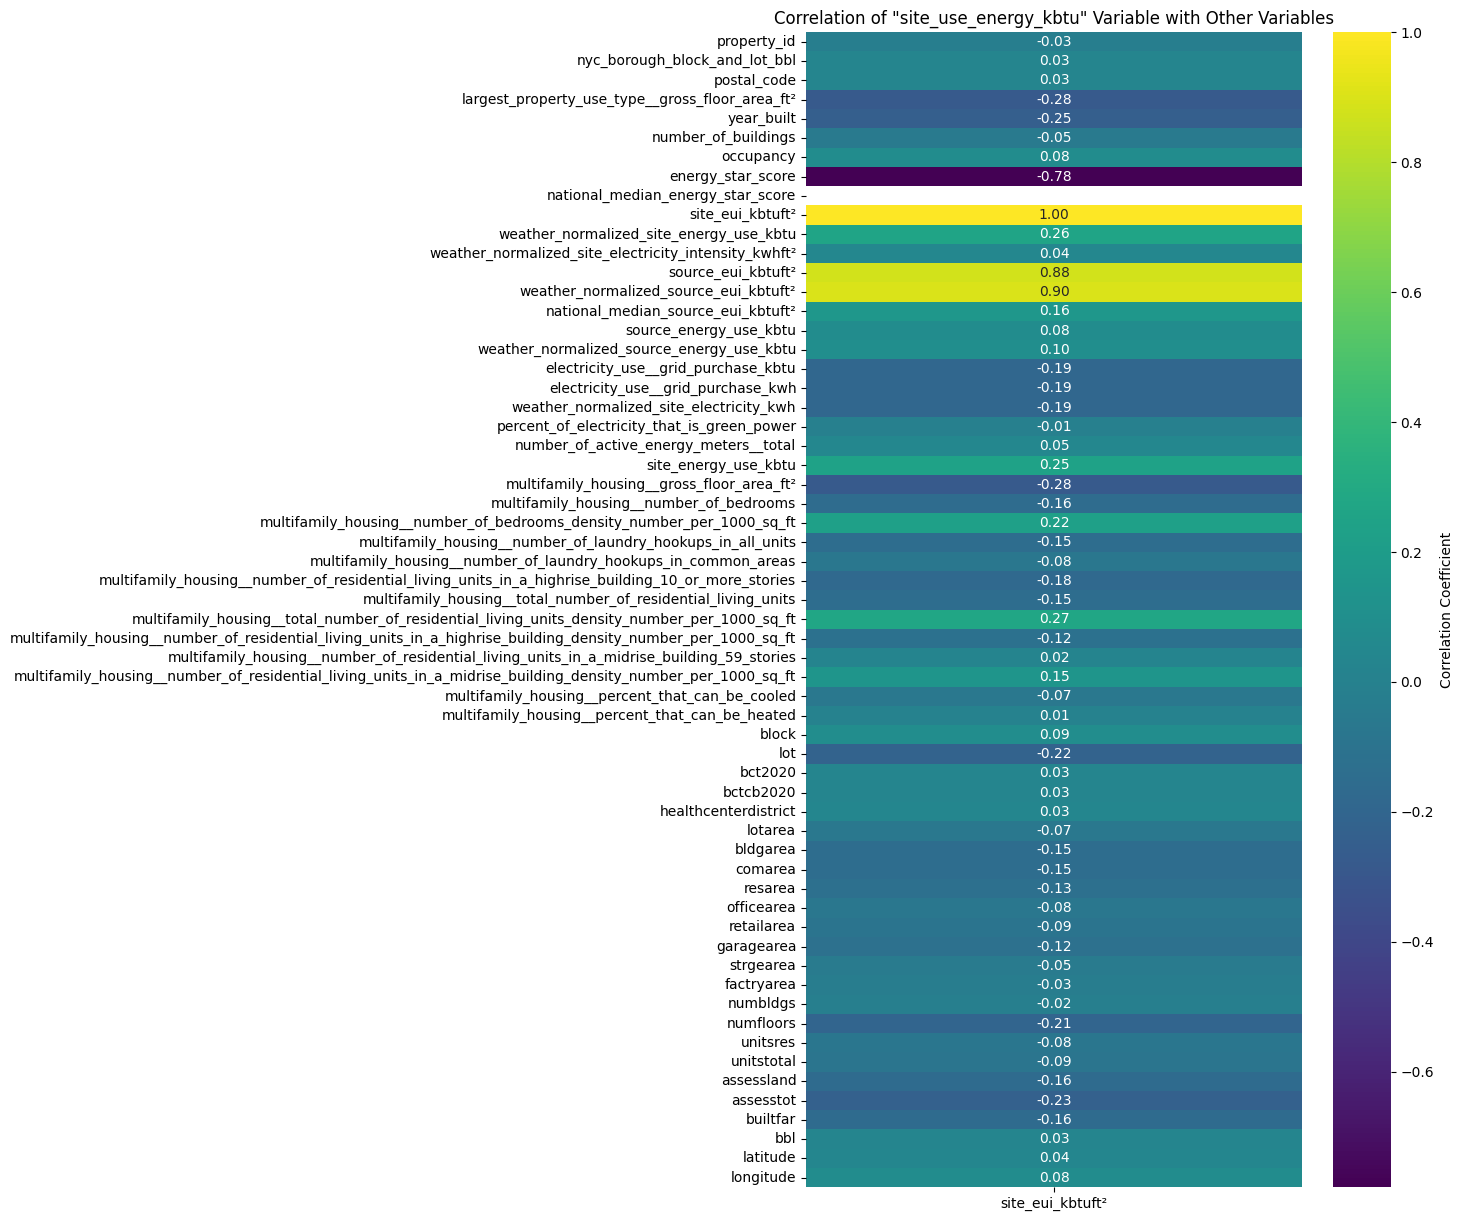

In [ ]:
# Check correlation with target variable (site_eui_kbtuft²)
corr_df = data.select_dtypes(include=['int', 'float'])

# Calculate the correlation matrix for the entire DataFrame
corr_matrix = corr_df.corr()
site_use_corr = corr_matrix[['site_eui_kbtuft²']]

plt.figure(figsize=(8, 15))
sns.heatmap(site_use_corr, annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation of "site_use_energy_kbtu" Variable with Other Variables')
plt.show()

We have to choose the predictor for our modeling. Some of the features are not reliable because sevreal reasons. Therefore, we have to remoe some variables
- Only have 1 value: `national_median_reference_property_type`, `national_median_energy_star_score`, `largest_property_use_type`, `construction_status`, `metered_areas_energy`, `_merge`
- Code like/identifier: `property_id`, `block`, `lot`, `bct2020`, `bctcb202`, `healthcenterdistrict`, `bbl`, `postal_code`, `nyc_borough_block_and_lot_bbl`
- Poisition: `longitude`, `latitude`
- Potential [leakage feature](https://en.wikipedia.org/wiki/Leakage_(machine_learning)#:~:text=Feature%20leakage,-Feature%20or%20column&text=These%20features%2C%20known%20as%20anachronisms,%22%20when%20predicting%20%22IsLate%22.): `site_eui_kbtuft²`, `weather_normalized_site_energy_use_kbtu`, `weather_normalized_site_electricity_intensity_kwhft²`, `source_eui_kbtuft²`, `weather_normalized_source_eui_kbtuft²`, `national_median_source_eui_kbtuft²`, `source_energy_use_kbtu`, `weather_normalized_source_energy_use_kbtu`, `electricity_use__grid_purchase_kbtu`, `electricity_use__grid_purchase_kwh`, `weather_normalized_site_electricity_kwh`

In [ ]:
# Define predictor and target variables
predictor = [
       'borough', 'city',
       'largest_property_use_type__gross_floor_area_ft²', 'year_built',
       'number_of_buildings',
       'occupancy',
       'energy_star_score',
       'energy_star_certification__eligibility',
       'percent_of_electricity_that_is_green_power',
       'number_of_active_energy_meters__total',
       'multifamily_housing__government_subsidized_housing',
       'multifamily_housing__gross_floor_area_ft²',
       'multifamily_housing__number_of_bedrooms',
       'multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft',
       'multifamily_housing__number_of_laundry_hookups_in_all_units',
       'multifamily_housing__number_of_laundry_hookups_in_common_areas',
       'multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories',
       'multifamily_housing__total_number_of_residential_living_units',
       'multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft',
       'multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft',
       'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories',
       'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft',
       'multifamily_housing__percent_that_can_be_cooled',
       'multifamily_housing__percent_that_can_be_heated',
       'zonedist1', 'bldgclass', 'landuse', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'ext', 'proxcode',
       'lottype', 'assessland', 'assesstot', 'builtfar',
]

target = ['site_eui_kbtuft²']

In [ ]:
# Export data
data.to_csv('merged_data_energy_pluto_no_outliers.csv')

# Split Data

In [ ]:
# Split to X y
X = data[predictor]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Display X_Train
X_train.sample(10, random_state=1)

,borough,city,largest_property_use_type__gross_floor_area_ft²,year_built,number_of_buildings,occupancy,energy_star_score,energy_star_certification__eligibility,percent_of_electricity_that_is_green_power,number_of_active_energy_meters__total,multifamily_housing__government_subsidized_housing,multifamily_housing__gross_floor_area_ft²,multifamily_housing__number_of_bedrooms,multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft,multifamily_housing__number_of_laundry_hookups_in_all_units,multifamily_housing__number_of_laundry_hookups_in_common_areas,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories,multifamily_housing__total_number_of_residential_living_units,multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft,multifamily_housing__percent_that_can_be_cooled,multifamily_housing__percent_that_can_be_heated,zonedist1,bldgclass,landuse,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,numbldgs,numfloors,unitsres,unitstotal,ext,proxcode,lottype,assessland,assesstot,builtfar
8688,BK,Brooklyn,52000.0,1900.0,1.0,100.0,55.0,False,0.0,5.0,False,52000.0,50.00,0.96154,23.0,0.0,24.0,24.0,0.46154,0.46154,0.0,0.00000,100.0,100.0,C5-2A,RM,4.0,5250.0,37628.0,9932.0,27696.0,5167.0,4765.0,0.0,0.0,0.0,1.0,10.0,23.0,25.0,0,0.0,0.0,900000.0,5666583.0,7.17
8956,BK,Brooklyn,69816.0,1922.0,1.0,100.0,76.0,True,0.0,6.0,False,69816.0,76.00,1.08858,0.0,0.0,0.0,66.0,0.94534,0.00000,66.0,0.94534,0.0,90.0,R7-1,D1,3.0,20000.0,69816.0,0.0,69816.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,66.0,66.0,N,1.0,5.0,450000.0,1617300.0,3.49
1497,BX,BRONX,67300.0,1926.0,1.0,100.0,100.0,False,0.0,8.0,False,67300.0,84.00,1.24814,0.0,0.0,0.0,60.0,0.89153,0.00000,60.0,0.89153,90.0,100.0,R6,C1,2.0,14100.0,64100.0,0.0,64100.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,60.0,60.0,N,0.0,3.0,158850.0,613350.0,4.55
4175,BK,Brooklyn,35160.0,1957.0,1.0,100.0,18.0,False,0.0,4.0,False,35160.0,60.00,1.70648,0.0,8.0,0.0,42.0,1.19454,0.00000,14.0,0.39818,90.0,90.0,R6A,D4,3.0,6950.0,35160.0,0.0,35160.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,40.0,40.0,N,2.0,3.0,163350.0,1894050.0,5.06
4219,MN,New York,30480.0,1917.0,1.0,100.0,70.0,False,0.0,6.0,False,30480.0,60.00,1.96850,0.0,0.0,0.0,31.0,1.01706,0.00000,31.0,1.01706,50.0,90.0,R8,C1,2.0,7294.0,25400.0,0.0,25400.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,31.0,31.0,N,2.0,5.0,102600.0,1435950.0,3.48
7587,MN,New York,33500.0,1900.0,1.0,100.0,75.0,True,0.0,6.0,False,33500.0,50.00,1.49254,0.0,0.0,0.0,36.0,1.07463,0.00000,36.0,1.07463,90.0,100.0,R7-2,C1,2.0,6297.0,33490.0,0.0,33490.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,36.0,36.0,N,3.0,5.0,180000.0,987750.0,5.32
4349,QN,Kew Gardens,105191.0,1923.0,1.0,100.0,69.0,False,0.0,5.0,False,105191.0,206.00,1.95834,40.0,10.0,0.0,84.0,0.79855,0.00000,84.0,0.79855,100.0,100.0,R5,RM,4.0,45898.0,105191.0,699.0,104492.0,699.0,0.0,0.0,0.0,0.0,1.0,5.0,83.0,84.0,0,0.0,2.0,787493.0,6567751.0,2.29
6371,MN,New York,99238.0,1956.0,1.0,100.0,28.0,False,0.0,17.0,False,99238.0,138.93,1.39997,0.0,0.0,92.0,92.0,0.92706,0.92706,0.0,0.00000,100.0,100.0,C1-9A,D4,3.0,8588.0,99238.0,3099.0,96139.0,980.0,2119.0,0.0,0.0,0.0,1.0,17.0,90.0,92.0,N,3.0,3.0,1291500.0,10945800.0,11.56
4695,QN,Queens,46140.0,1931.0,1.0,95.0,93.0,False,0.0,10.0,False,46140.0,80.00,1.73385,0.0,5.0,0.0,53.0,1.14868,0.00000,53.0,1.14868,0.0,100.0,R6A,D1,3.0,9384.0,46140.0,0.0,46140.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,53.0,53.0,N,0.0,3.0,253350.0,2249100.0,4.92
8738,MN,New York,27969.0,1900.0,2.0,100.0,64.0,False,0.0,6.0,False,27969.0,51.00,1.82345,0.0,3.0,0.0,30.0,1.07262,0.00000,30.0,1.07262,90.0,100.0,R7A,RM,4.0,5619.0,27154.0,2703.0,24451.0,0.0,2703.0,0.0,0.0,0.0,2.0,6.0,30.0,32.0,0,3.0,5

# Preprocessing

(Transform, Scaling, One Hot Encoding, etc.)

In [ ]:
# Printing all categorical columns
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()

print("Categorical columns:")
for category_column in categorical_features:
    print(f'- {category_column}')

Categorical columns:
- borough
- city
- zonedist1
- bldgclass
- landuse
- ext
- proxcode
- lottype


In [ ]:
# Printing all numerical columns
numerical_features = X_train.select_dtypes(include=['number']).columns.to_list()

print("Numerical columns:")
for num_column in numerical_features:
    print(f'- {num_column}')

Numerical columns:
- largest_property_use_type__gross_floor_area_ft²
- year_built
- number_of_buildings
- occupancy
- energy_star_score
- percent_of_electricity_that_is_green_power
- number_of_active_energy_meters__total
- multifamily_housing__gross_floor_area_ft²
- multifamily_housing__number_of_bedrooms
- multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft
- multifamily_housing__number_of_laundry_hookups_in_all_units
- multifamily_housing__number_of_laundry_hookups_in_common_areas
- multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories
- multifamily_housing__total_number_of_residential_living_units
- multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft
- multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft
- multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories
- multifamily_housing__number_of_r

In [ ]:
# Check number of unique value
for cat_column in categorical_features:
  print(f'{cat_column} = {X_train[cat_column].nunique()}')

borough = 5
city = 73
zonedist1 = 125
bldgclass = 44
landuse = 7
ext = 5
proxcode = 4
lottype = 9


We have 6 categorical columns and 50 numerical columns. To decide what treatment to implement on the features, we have to see first the data distribution.

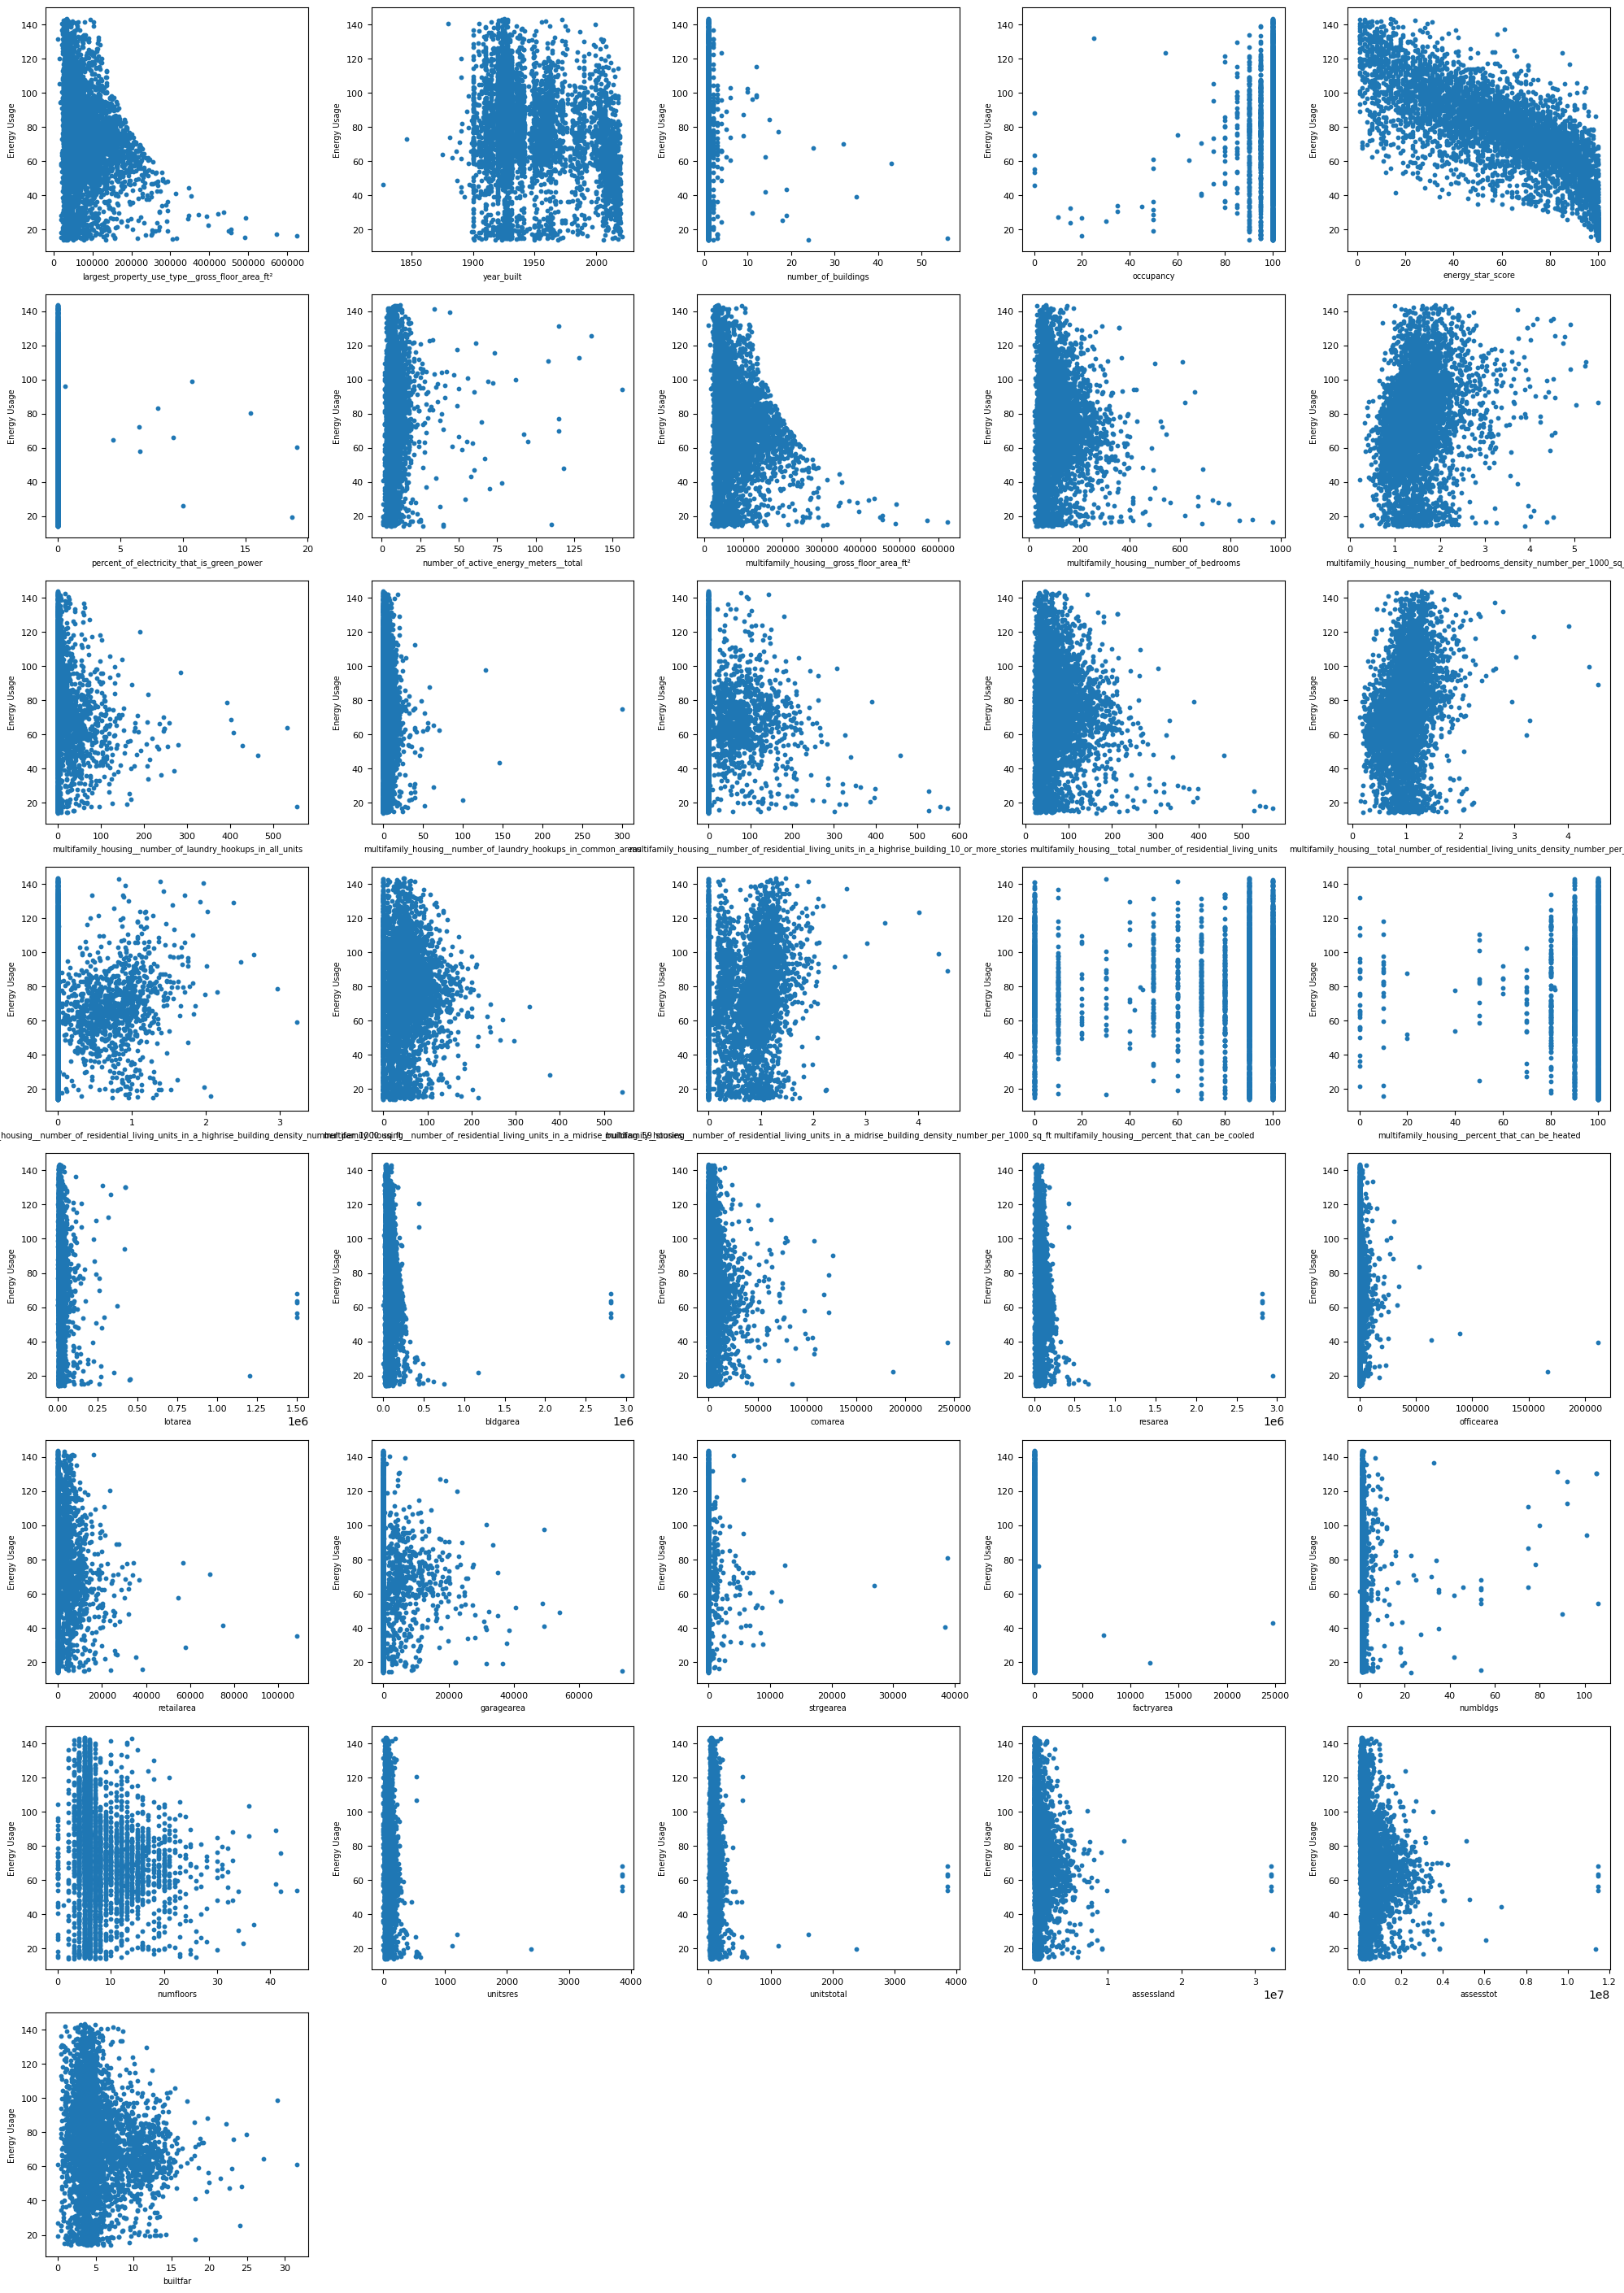

In [ ]:
plt.figure(figsize=(20, 35))

for i in range(len(numerical_features)):
    plt.subplot(10, 5, i + 1)
    plt.scatter(x=X_train[numerical_features[i]], y=y_train, s=10)

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.xlabel(numerical_features[i], fontsize=7)
    plt.ylabel('Energy Usage', fontsize=7)

plt.tight_layout()
plt.show()


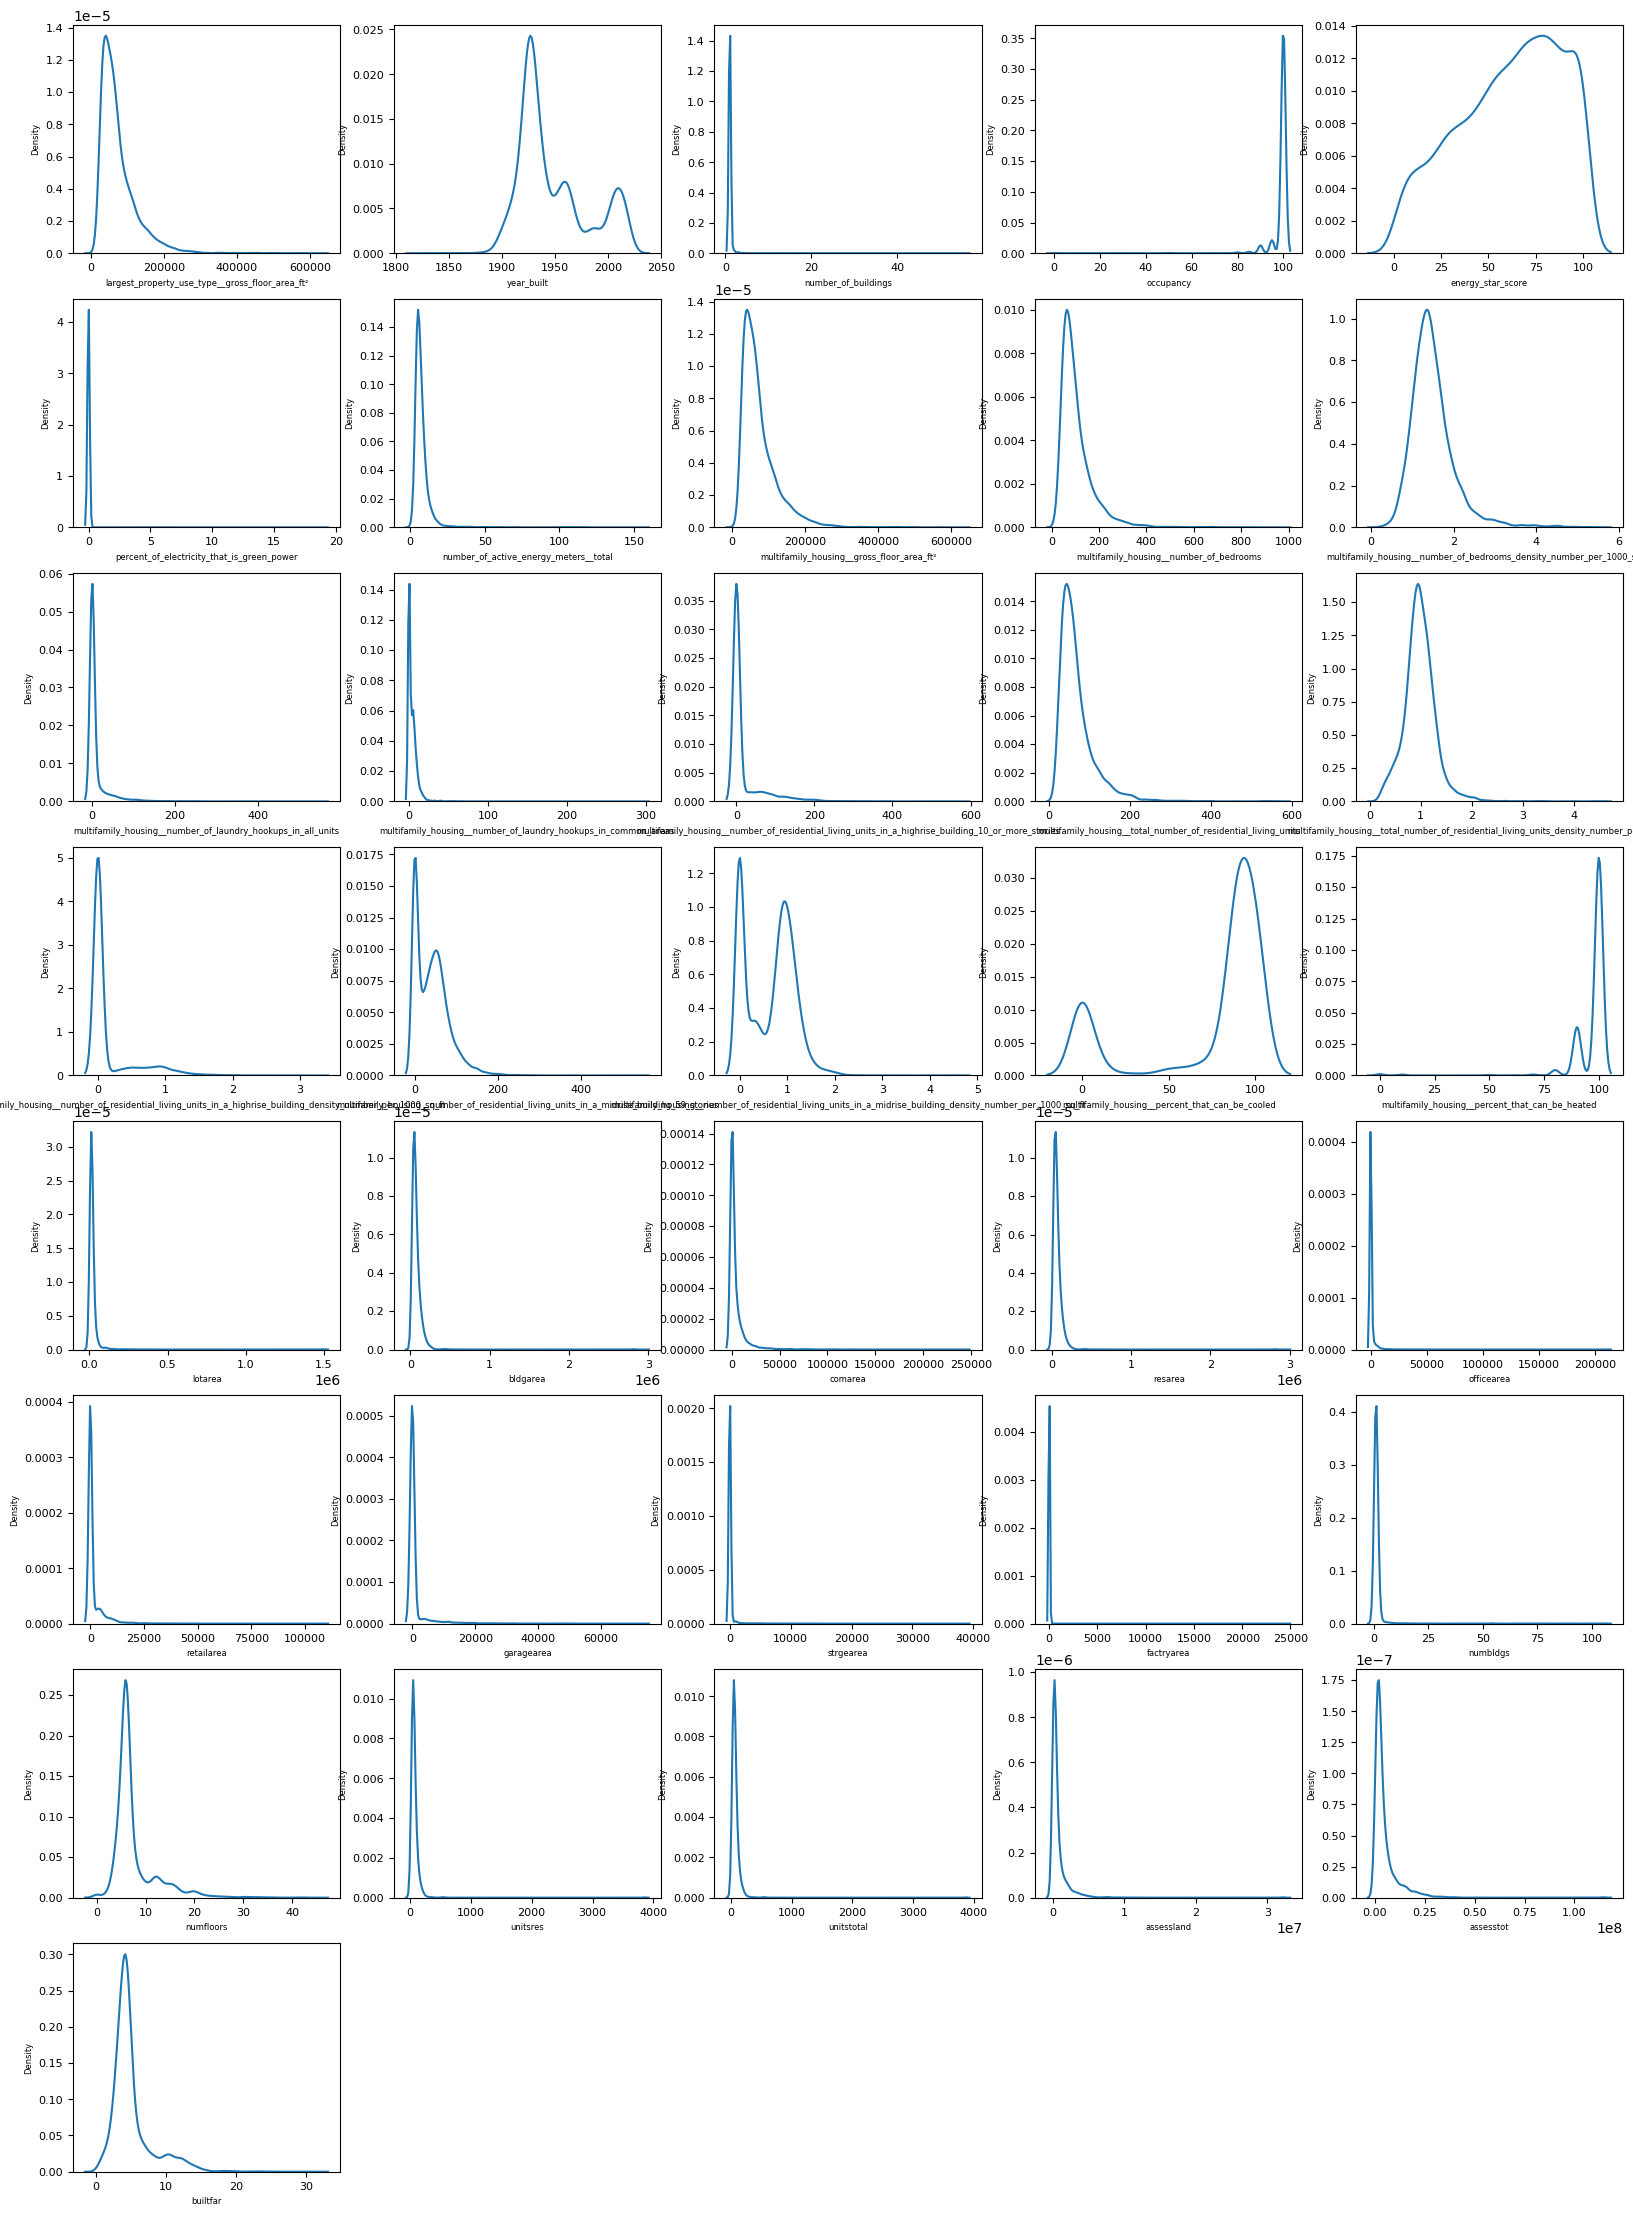

In [ ]:
# Plot to see each numerical variables distribution
plt.figure(figsize = (20, 35))

for i in range(len(numerical_features)):
    plt.subplot(10, 5, i+1)
    sns.kdeplot(data=X_train, x=X_train[numerical_features[i]])

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.xlabel(numerical_features[i], fontsize=6)
    plt.ylabel('Density', fontsize=6)

Most of the numerical features distribution is rigth skewed indicating that there are outliers with very high value.

In [ ]:
# Make pipeline for categorical features
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value='missing')),
    ('onehot encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Make pipeline for numerical features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Column Transformer
transformer = ColumnTransformer([
    ('cat pipe', cat_transformer, categorical_features),
    ('num pipe', num_transformer, numerical_features)],
    remainder = 'passthrough'
)

In [ ]:
# Define models
models = {
    "XGBoost": XGBRegressor(random_state=0),
    "RandomForest": RandomForestRegressor(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150),
    "SVM": SVR(),
    "LassoRegression": Lasso(alpha=1.0)
}

models

{'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...),
 'RandomForest': RandomForestRegressor(min_samples_leaf=2, n_estimators=150),
 'SVM': SVR(),
 'LassoRegression': Lasso()}

# Benchmark Modeling

Fit, Cross-Validation, and Evaluation

In [ ]:
# Prepare result DataFrame
results = {
    "model": [],
    "train_rmse": [],
    "test_rmse": [],
    "train_mae": [],
    "test_mae": [],
    "train_mape": [],
    "test_mape": [],
    "training_time": []
}

# Loop through models
for model_name, model in models.items():

    model_pipeline = Pipeline([
        ('transformer', transformer),
        ('regressor', model)
    ])

    # Store the cross-validation results
    results["model"].append(model_name)

    # Training and evaluation
    start_time = time.time()
    print(f"Training and evaluating {model_name}...")
    model_pipeline.fit(X_train, y_train)

    y_train_pred = model_pipeline.predict(X_train)
    y_test_pred = model_pipeline.predict(X_test)

    # Calculate metrics
    results["train_rmse"].append(np.round(np.sqrt(mse(y_train, y_train_pred)), 2))
    results["test_rmse"].append(np.round(np.sqrt(mse(y_test, y_test_pred)), 2))
    results["train_mae"].append(np.round(mae(y_train, y_train_pred), 2))
    results["test_mae"].append(np.round(mae(y_test, y_test_pred), 2))
    results["train_mape"].append(np.round(mape(y_train, y_train_pred), 4))
    results["test_mape"].append(np.round(mape(y_test, y_test_pred), 4))

    end_time = time.time()
    processing_time = end_time - start_time
    results["training_time"].append(np.round(processing_time, 2))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Training and evaluating XGBoost...
Training and evaluating RandomForest...
Training and evaluating SVM...
Training and evaluating LassoRegression...


In [ ]:
# Report modeling results
results_df.sort_values('test_mape', ascending=True)

,model,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,training_time
1,RandomForest,3.85,9.01,2.56,6.13,0.0425,0.1051,72.43
0,XGBoost,3.02,8.86,2.26,6.21,0.0353,0.1060,3.23
3,LassoRegression,12.86,13.05,9.49,9.54,0.1983,0.2034,0.19
2,SVM,25.15,25.79,19.25,20.02,0.3928,0.4168,13.34


In [ ]:
# Find the best model based on a specific criterion, such as test MAPE
best_model_name = results_df.sort_values("test_mape").iloc[0]["model"]

# Extract the best model from the models dictionary
best_model = models[best_model_name]

# Create a pipeline
best_model_pipeline = Pipeline([
    ('transformer', transformer),
    ('regressor', XGBRegressor(random_state=0))
])

# Fit the pipeline
best_model_pipeline.fit(X_train, y_train)
best_model = best_model_pipeline.named_steps['regressor']

# Get feature importances
importances = best_model.feature_importances_

# Extract the ColumnTransformer from the pipeline
transformer = best_model_pipeline.named_steps['transformer']

# Get the feature names after transformation
feature_names = transformer.get_feature_names_out()

# Sort the features by importance
sorted_idx = np.argsort(importances)[::-1]
top_idx = sorted_idx[:10]
top_importances = importances[top_idx]
top_feature_names = feature_names[top_idx]
top_feature_names = [name.split("num pipe__")[-1] for name in top_feature_names]
top_feature_names = [name.split("cat pipe__")[-1] for name in top_feature_names]

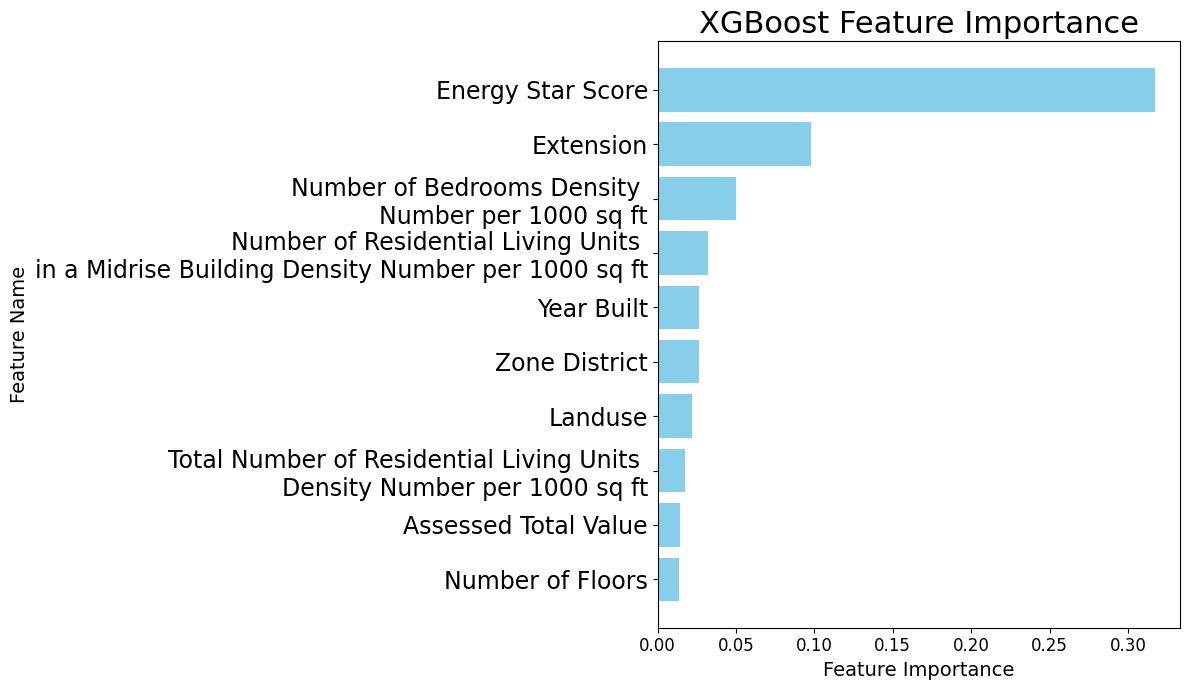

In [ ]:
# Map the cleaned names to desired labels
name_mapping = {
    "bldgarea": "Building Area",
    "resarea": "Residential Area",
    "energy_star_score": "Energy Star Score",
    "largest_property_use_type__gross_floor_area_ft²": "Largest Property Use Type - Gross Floor Area (ft²)",
    "multifamily_housing__number_of_bedrooms": "Multifamily Housing - Number of Bedrooms",
    "multifamily_housing__total_number_of_residential_living_units": "Multifamily Housing - Total Number of Residential Living Units",
    "multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories": "Multifamily Housing - Number of Residential Living Units \nin a Mid-Rise Building (5-9 Stories)",
    "landuse_5.0": "Landuse",
    "bldgclass_C9": "Building Class",
    "year_built": "Year Built",
    "ext_0": "Extension",
    "multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft": "Number of Bedrooms Density \nNumber per 1000 sq ft",
    "multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft": "Number of Residential Living Units \nin a Midrise Building Density Number per 1000 sq ft",
    "multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft": "Total Number of Residential Living Units \nDensity Number per 1000 sq ft",
    "zonedist1_C5-P": "Zone District C5-P",
    "zonedist1_R8X": "Zone District",
    "assesstot": "Assessed Total Value",
    "numfloors": "Number of Floors"
}
mapped_feature_names = [name_mapping.get(name, name) for name in top_feature_names]

# Create a bar plot
plt.figure(figsize=(12, 7))
plt.barh(mapped_feature_names, top_importances, color='skyblue')
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("XGBoost Feature Importance", fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=17)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Modeling with Important Feature

In [ ]:
# Create new X_train with top 10 features
selected_features = ['energy_star_score','ext','multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft',
                      'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft',
                      'year_built','zonedist1','landuse','multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft',
                      'assesstot','numfloors']
X_train_fs = X_train[selected_features]
X_test_fs = X_test[selected_features]

In [ ]:
# Column Transformer for the new X_train
transformer_fs = ColumnTransformer([
    ('cat pipe', cat_transformer, list(X_train_fs.select_dtypes(include=["object"]).columns)),
    ('num pipe', num_transformer, list(X_train_fs.select_dtypes(include=["int", "float"]).columns))],
    remainder='passthrough'
)

# Create a pipeline for the new X_train
best_model_pipeline_fs = Pipeline([
    ('transformer', transformer_fs),
    ('regressor', XGBRegressor(random_state=0))
])

best_model_pipeline_fs

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot '
                                                                   'encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ext', 'zonedist1',
                                                   'landuse']),
                                                 ('num pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [ ]:
# Fit the pipeline for the new X_train
best_model_pipeline_fs.fit(X_train_fs, y_train)

y_train_fs_pred = best_model_pipeline_fs.predict(X_train_fs)
y_test_fs_pred = best_model_pipeline_fs.predict(X_test_fs)

In [ ]:
# Evaluate the model using train data
mse_train_fs = mse(y_train, y_train_fs_pred)
mae_train_fs = mae(y_train, y_train_fs_pred)
mape_train_fs = mape(y_train, y_train_fs_pred)
rmse_train_fs = np.sqrt(mse_train_fs)

print('RMSE:', round(rmse_train_fs, 2),
      '\nMSE:', round(mse_train_fs, 2),
      '\nMAE:', round(mae_train_fs, 2),
      '\nMAPE:', round(mape_train_fs, 2))

RMSE: 4.63 
MSE: 21.4 
MAE: 3.36 
MAPE: 0.05


In [ ]:
# Evaluate the model using test data
mse_test_fs = mse(y_test, y_test_fs_pred)
mae_test_fs = mae(y_test, y_test_fs_pred)
mape_test_fs = mape(y_test, y_test_fs_pred)
rmse_test_fs = np.sqrt(mse_test_fs)

print('RMSE:', round(rmse_test_fs, 2),
      '\nMSE:', round(mse_test_fs, 2),
      '\nMAE:', round(mae_test_fs, 2),
      '\nMAPE:', round(mape_test_fs, 2))

RMSE: 8.95 
MSE: 80.05 
MAE: 6.21 
MAPE: 0.1


# Export Machine Learning Model

In [ ]:
# Fit model to all dataset
xgb_v1_mape_15 = best_model_pipeline_fs #model naming format: <model_name>_<data_version>_<metric>_<value>
xgb_v1_mape_15.fit(X[selected_features], y)

# Save model
model_file_name = 'xgb_v2_mape_10.pkl'
pickle.dump(xgb_v1_mape_15, open(model_file_name, 'wb'))

In [ ]:
# Pickle load
file = 'xgb_v2_mape_10.pkl'
model_loaded = pickle.load((open(file, 'rb')))

In [ ]:
model_loaded

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot '
                                                                   'encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ext', 'zonedist1',
                                                   'landuse']),
                                                 ('num pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

# Test Model to a New Dataset

In [ ]:
data[selected_features].sample(random_state=1)

,energy_star_score,ext,multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft,year_built,zonedist1,landuse,multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft,assesstot,numfloors
8456,28.0,G,1.54076,1.22798,1972.0,R6,3.0,1.22798,4792950.0,6.0


In [ ]:
sample_data = pd.DataFrame({
    'energy_star_score': [28],
    'ext': ['G'],
    'multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft': [1.54076],
    'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft':[1.22798],
    'year_built':[1972.0],
    'zonedist1':['R6'],
    'landuse': [3.0],
    'multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft':[1.22798],
    'assesstot':[4792950.0],
    'numfloors': [6.0]
})

In [ ]:
model_loaded.predict(sample_data)

array([104.35766], dtype=float32)

In [ ]:
data.loc[8456]['site_eui_kbtuft²']

114.2

In [ ]:
# Predict to new unknown data
new_data = pd.DataFrame({
    'energy_star_score': [75],
    'ext': ['G'],
    'multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft': [3.2],
    'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft': [4.5],
    'year_built': [1987],
    'zonedist1': ['R4'],
    'landuse': [3],
    'multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft': [6.0],
    'assesstot': [500000],
    'numfloors': [5]
})

model_loaded.predict(new_data)

array([107.09082], dtype=float32)

# Analyzing Results

In [ ]:
# Predict all data
predicted_energy = model_loaded.predict(X[selected_features])
predicted_energy

array([65.74987 , 18.156084, 95.852974, ..., 69.52206 , 49.91802 ,
       31.070902], dtype=float32)

In [ ]:
# Create geodataframe
gdf = data.copy()
gdf['predicted_energy'] = predicted_energy

gdf = gpd.GeoDataFrame(
    gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude), crs="EPSG:4326"
)

gdf.head()

,property_id,nyc_borough_block_and_lot_bbl,city,postal_code,national_median_reference_property_type,largest_property_use_type,largest_property_use_type__gross_floor_area_ft²,year_built,construction_status,number_of_buildings,occupancy,metered_areas_energy,energy_star_score,national_median_energy_star_score,energy_star_certification__eligibility,site_eui_kbtuft²,weather_normalized_site_energy_use_kbtu,weather_normalized_site_electricity_intensity_kwhft²,source_eui_kbtuft²,weather_normalized_source_eui_kbtuft²,national_median_source_eui_kbtuft²,source_energy_use_kbtu,weather_normalized_source_energy_use_kbtu,electricity_use__grid_purchase_kbtu,electricity_use__grid_purchase_kwh,weather_normalized_site_electricity_kwh,percent_of_electricity_that_is_green_power,number_of_active_energy_meters__total,site_energy_use_kbtu,multifamily_housing__government_subsidized_housing,multifamily_housing__gross_floor_area_ft²,multifamily_housing__number_of_bedrooms,multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft,multifamily_housing__number_of_laundry_hookups_in_all_units,multifamily_housing__number_of_laundry_hookups_in_common_areas,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_10_or_more_stories,multifamily_housing__total_number_of_residential_living_units,multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_highrise_building_density_number_per_1000_sq_ft,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_59_stories,multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft,multifamily_housing__percent_that_can_be_cooled,multifamily_housing__percent_that_can_be_heated,borough,block,lot,bct2020,bctcb2020,healthcenterdistrict,zonedist1,bldgclass,landuse,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,numbldgs,numfloors,unitsres,unitstotal,ext,proxcode,lottype,assessland,assesstot,builtfar,bbl,latitude,longitude,_merge,predicted_energy,geometry
0,21205224.0,4006520042,Long Island City,11103.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,25000.0,2010.0,Existing,1.0,100.0,Whole Property,71.0,50.0,False,66.7,1758894.6,7.0,112.3,115.4,128.1,2806470.4,2885158.1,603862.9,176982.1,173893.6,0.0,8.0,1666390.8,False,25000.0,30.0,1.20000,0.0,6.0,0.0,25.0,1.00000,0.00000,25.0,1.00000,0.0,100.0,QN,652.0,42.0,4006502.0,4.006502e+10,41.0,R6B,D7,4.0,6690.0,34146.0,4000.0,30146.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,25.0,26.0,N,0.0,5.0,170550.0,1727100.0,5.10,4006520042,40.769008,-73.913395,both,65.749870,POINT (-73.91340 40.76901)
1,2665352.0,1012060001,New York,10025.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,260780.0,1970.0,Existing,1.0,100.0,Whole Property,100.0,50.0,False,19.2,5022480.9,4.7,48.2,48.2,114.3,12615136.7,12615136.7,4195161.0,1229531.2,1229531.2,0.0,6.0,5022480.9,False,260780.0,317.0,1.21558,0.0,1.0,208.0,208.0,0.79761,0.79761,0.0,0.00000,0.0,100.0,MN,1206.0,1.0,1017700.0,1.017701e+10,16.0,C1-9,D7,4.0,25177.0,244841.0,33619.0,211222.0,2102.0,0.0,31517.0,0.0,0.0,1.0,30.0,203.0,205.0,N,1.0,3.0,1125000.0,8226000.0,9.72,1012060001,40.790459,-73.968816,both,18.156084,POINT (-73.96882 40.79046)
4,2665431.0,1020900036,New York,10031.0,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,89199.0,1983.0,Existing,1.0,100.0,Whole Property,54.0,50.0,False,101.0,9721541.6,5.8,141.3,148.8,145.3,12600228.0,13272311.4,1796278.7,526459.1,513262.8,0.0,14.0,9006419.3,False,89199.0,174.0,1.95070,0.0,1.0,0.0,51.0,0.57176,0.00000,51.0,0.57176,0.0,100.0,MN,2090.0,36.0,1022900.0,1.022901e+10,17.0,R8,D7,4.0,15000.0,68735.0,5422.0,63313.0,0.0,5422.0,0.0,0.0,0.0,1.0,6.0,50.0,55.0,N,3.0,3.0,395550.0,2327400.0,4.58,1020900036,40.825764,-73.951539,both,95.852974,POINT (-73.95154 40.82576)
5,2665443.0,1021220120,New York,10032.0,Fannie Mae Industry Survey - Multifamily,Multifamil

In [ ]:
# calculate evaluation metrics
gdf['squared_error'] = (gdf['predicted_energy'] - gdf['site_eui_kbtuft²'])**2
gdf['absolute_error'] = abs(gdf['predicted_energy'] - gdf['site_eui_kbtuft²'])
gdf['absolute_perc_error'] = (abs(gdf['predicted_energy'] - gdf['site_eui_kbtuft²']) / gdf['site_eui_kbtuft²']) * 100
gdf['root_squared_error'] = np.sqrt(gdf['squared_error'])
rmse = np.sqrt(gdf['squared_error'].mean())
mae = gdf['absolute_error'].mean()
mape = gdf['absolute_perc_error'].mean()


<Figure size 2000x2000 with 0 Axes>

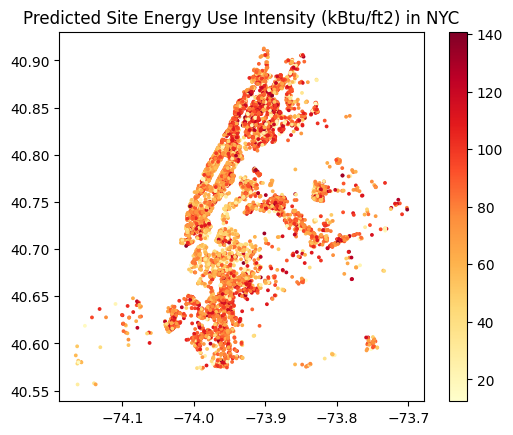

In [ ]:
# Plot energy prediction
plt.figure(figsize=(20,20))
gdf.plot(column='predicted_energy', legend=True, cmap='YlOrRd', markersize=3)
plt.title("Predicted Site Energy Use Intensity (kBtu/ft2) in NYC")
plt.show()

<Figure size 2000x2000 with 0 Axes>

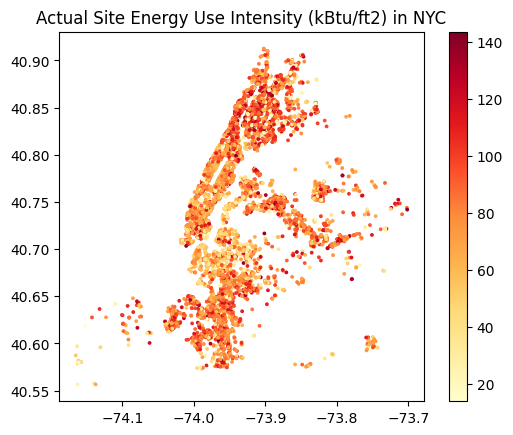

In [ ]:
# Plot energy actual
plt.figure(figsize=(20,20))
gdf.plot(column='site_eui_kbtuft²', legend=True, cmap='YlOrRd', markersize=3)
plt.title("Actual Site Energy Use Intensity (kBtu/ft2) in NYC")
plt.show()

<Figure size 2000x2000 with 0 Axes>

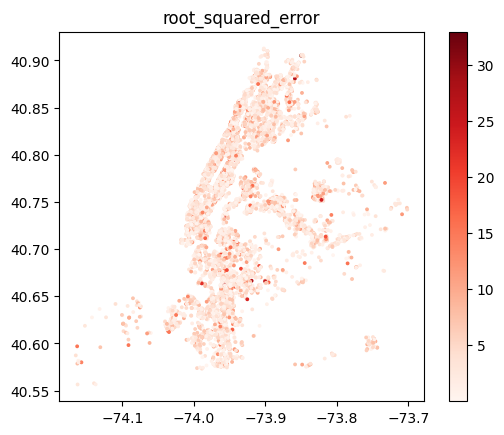

<Figure size 2000x2000 with 0 Axes>

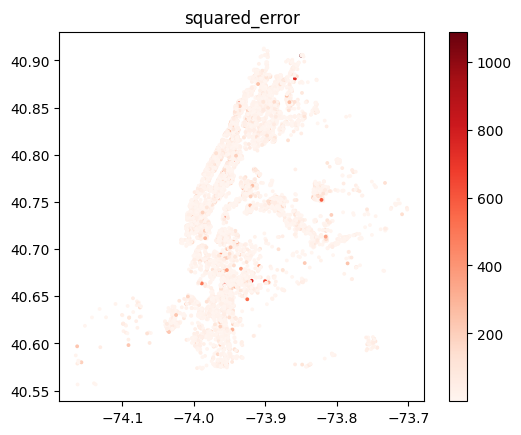

<Figure size 2000x2000 with 0 Axes>

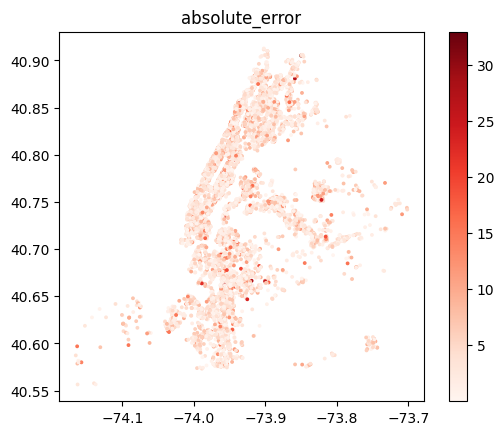

<Figure size 2000x2000 with 0 Axes>

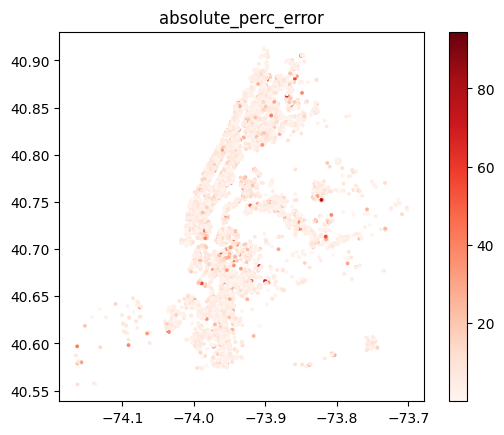

In [ ]:
# Plot error
for metric in ['root_squared_error', 'squared_error', 'absolute_error', 'absolute_perc_error']:
  plt.figure(figsize=(20,20))
  gdf.plot(column=metric, legend=True, cmap='Reds', markersize=3)
  plt.title(metric)
  plt.show()

In [ ]:
# Analyze error
for metric in ['root_squared_error', 'squared_error', 'absolute_error', 'absolute_perc_error']:
    sorted_metric = gdf.sort_values(metric, ascending=False).head(100)[selected_features]
    mean_metric= sorted_metric['energy_star_score'].mean()
    print(f"{metric}: {mean_metric}")
    print(sorted_metric.describe().T[['50%', 'mean']])
    print()

root_squared_error: 62.92
                                                             50%          mean
energy_star_score                                   6.950000e+01  6.292000e+01
multifamily_housing__number_of_bedrooms_density...  1.523160e+00  1.588887e+00
multifamily_housing__number_of_residential_livi...  7.854450e-01  6.396453e-01
year_built                                          1.936500e+03  1.953830e+03
multifamily_housing__total_number_of_residentia...  9.788450e-01  1.002789e+00
assesstot                                           2.166075e+06  3.522468e+06
numfloors                                           6.000000e+00  7.040000e+00

squared_error: 62.92
                                                             50%          mean
energy_star_score                                   6.950000e+01  6.292000e+01
multifamily_housing__number_of_bedrooms_density...  1.523160e+00  1.588887e+00
multifamily_housing__number_of_residential_livi...  7.854450e-01  6.396453e-01
year

In [ ]:
error_analysis_features = ['energy_star_score','ext','multifamily_housing__number_of_bedrooms_density_number_per_1000_sq_ft',
                  'multifamily_housing__number_of_residential_living_units_in_a_midrise_building_density_number_per_1000_sq_ft',
                  'year_built','zonedist1','landuse',
                  'multifamily_housing__total_number_of_residential_living_units_density_number_per_1000_sq_ft',
                  'assesstot', 'numfloors', 'root_squared_error', 'squared_error', 'absolute_error', 'absolute_perc_error',
                    'site_eui_kbtuft²', 'predicted_energy'
                  ]
bad_acc_100 = gdf.sort_values('squared_error', ascending=False).head(100)[error_analysis_features]

In [ ]:
bad_acc_100.to_csv('bad_acc_100.csv')

In [ ]:
import xgboost
print(xgboost.__version__)

2.0.3


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2
